In [48]:
# lib

import os
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import tensorflow as tf
# from PIL import Image
from scipy import ndimage

import math
from lr_utils import load_dataset
import sklearn
import sklearn.datasets
import sklearn.linear_model
import scipy.io
%matplotlib inline


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# helper functions

def sigmoid(x):
    '''
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    '''
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    '''
    Compute the relu of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- relu(x)
    '''
    s = np.maximum(0,x)
    
    return s

def load_planar_dataset(seed):
    
    np.random.seed(seed)
    
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return (X, Y)

def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:]) # your train set features
    train_set_y_orig = np.array(train_dataset['train_set_y'][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:]) # your test set features
    test_set_y_orig = np.array(test_dataset['test_set_y'][:]) # your test set labels

    classes = np.array(test_dataset['list_classes'][:]) # the list of classes
    
    train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
    
    train_set_x = train_set_x_orig/255
    test_set_x = test_set_x_orig/255

    return (train_set_x, train_set_y, test_set_x, test_set_y, classes)

def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T        ;       train_Y = data['y'].T
    test_X = data['Xval'].T      ;       test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return (train_X, train_Y,
            test_X, test_Y)


def load_planar_dataset(randomness, seed):
    
    np.random.seed(seed)
    
    m = 50
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 2 # maximum ray of the flower

    for j in range(2):
        
        ix = range(N*j,N*(j+1))
        if j == 0:
            t = np.linspace(j, 4*3.1415*(j+1),N) #+ np.random.randn(N)*randomness # theta
            r = 0.3*np.square(t) + np.random.randn(N)*randomness # radius
        if j == 1:
            t = np.linspace(j, 2*3.1415*(j+1),N) #+ np.random.randn(N)*randomness # theta
            r = 0.2*np.square(t) + np.random.randn(N)*randomness # radius
            
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return (X, Y)

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [51]:
# NN network modules

def initialize_parameters(layer_dims):
    '''
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network    
    Returns:
    parameters -- python dictionary containing your parameters 'W1', 'b1', ..., 'WL', 'bL':
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])     
    '''    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def forward_propagation(X, parameters):
    '''
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters 'W1', 'b1', 'W2', 'b2', 'W3', 'b3':
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    '''        
    # retrieve parameters
    W1 = parameters['W1'];     b1 = parameters['b1']
    W2 = parameters['W2'];     b2 = parameters['b2']
    W3 = parameters['W3'];     b3 = parameters['b3']
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = (W1 @  X) + b1  ;   A1 = relu(Z1)
    Z2 = (W2 @ A1) + b2  ;   A2 = relu(Z2)
    Z3 = (W3 @ A2) + b3  ;   A3 = sigmoid(Z3)
    
    cache = ( Z1, A1, W1, b1,
              Z2, A2, W2, b2,
              Z3, A3, W3, b3 )
    
    return (A3, cache)

def backward_propagation(X, Y, cache):
    '''
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true 'label' vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    '''
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * (dZ3 @ A2.T)
    db3 = 1./m * np.sum(dZ3, axis= 1, keepdims = True)
    
    dA2 = W3.T @ dZ3
    dZ2 = dA2 * np.int64(A2 > 0)
    dW2 = 1./m * ( dZ2 @ A1.T )
    db2 = 1./m * np.sum(dZ2, axis= 1, keepdims = True)
    
    dA1 = W2.T @ dZ2
    dZ1 = dA1 * np.int64(A1 > 0)
    dW1 = 1./m * ( dZ1 @ X.T )
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {            'dZ3': dZ3, 'dW3': dW3, 'db3': db3,
                 'dA2': dA2, 'dZ2': dZ2, 'dW2': dW2, 'db2': db2,
                 'dA1': dA1, 'dZ1': dZ1, 'dW1': dW1, 'db1': db1 }
    
    return gradients

def update_parameters(parameters, grads, learning_rate):
    '''
    Update parameters using gradient descent    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(i)] = Wi
                    parameters['b' + str(i)] = bi
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(i)] = dWi
                    grads['db' + str(i)] = dbi
    learning_rate -- the learning rate, scalar.    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    '''    
    n = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(n):
        parameters['W' + str(k+1)] = parameters['W' + str(k+1)] - learning_rate * grads['dW' + str(k+1)]
        parameters['b' + str(k+1)] = parameters['b' + str(k+1)] - learning_rate * grads['db' + str(k+1)]
        
    return parameters

def compute_cost(a3, Y):
    '''
    Implement the cost function    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- 'true' labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function
    '''
    m = Y.shape[1]    
    logprobs = ( -np.log(a3) * Y )  +  ( -np.log(1 - a3) * (1 - Y) )
    cost = 1./m * np.nansum(logprobs)
    
    return cost

def predict(X, y, parameters):
    '''
    This function is used to predict the results of a  n-layer neural network.    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model    
    Returns:
    p -- predictions for the given dataset X
    '''    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results
    print('Accuracy: '  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

def predict_dec(parameters, X):
    '''
    Used for plotting decision boundary.    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    '''
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

In [52]:
# matplot setting
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying the cost function,<br>from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} $$
to:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} $$

<br>
Backward propagation need to be modified as well. All the gradients have to be computed with respect to the new cost. 
The changes only concern dJ/dW1, dJ/dW2 and dJ/dW3. For each, regularization term's gradient should be included ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$)

In [53]:
# regularization modules

def compute_cost_with_regularization(A3, Y, parameters, lambd):
    '''
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))    
    '''
    m = Y.shape[1]
    W1 = parameters['W1']; W2 = parameters['W2']; W3 = parameters['W3']
    
    cross_entropy_cost = compute_cost( A3, Y )
    L2_reg_cost = (1./m * lambd/2.) *\
                  (  np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) )
    
    cost = cross_entropy_cost + L2_reg_cost
    
    return(cost)

def backward_propagation_with_regularization(X, Y, cache, lambd):
    '''
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables    
    '''
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y    
    dW3 = 1./m * (dZ3 @ A2.T) + lambd/m * W3
    db3 = 1./m * np.sum(dZ3, axis= 1, keepdims = True)    
    
    dA2 = W3.T @ dZ3
    dZ2 = dA2 * np.int64(A2 > 0)
    dW2 = 1./m * (dZ2 @ A1.T) + lambd/m * W2
    db2 = 1./m * np.sum(dZ2, axis= 1, keepdims = True)
    
    dA1 = W2.T @ dZ2
    dZ1 = dA1 * np.int64(A1 > 0)
    dW1 = 1./m * (dZ1 @ X.T) + lambd/m * W1
    db1 = 1./m * np.sum(dZ1, axis= 1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1 }
    
    return(gradients)

### Dropout

is a common regularization technique that randomly shuts down some neurons in each iteration

In [54]:
# backdrop modules

def forward_propagation_with_dropout( X, parameters, keep_prob= 0.5 ):
    '''
    Implements the forward propagation:
        LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation    
    '''    
    np.random.seed(1)    
    
    # retrieve paras
    W1 = parameters["W1"]; b1 = parameters["b1"]
    W2 = parameters["W2"]; b2 = parameters["b2"]
    W3 = parameters["W3"]; b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    
    Z1 = W1 @ X + b1
    A1 = relu(Z1)
    
    D1 = np.random.rand( A1.shape[0], A1.shape[1] ) # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    A1 = A1 * (D1 < keep_prob).astype(int) # Step 2: shut down some neurons of A1 based on D1 = 0 or 1 (using keep_prob as the threshold)
    A1 /= keep_prob                        # Step 3: scale the value of neurons that haven't been shut down
   
    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)    
    D2 = np.random.rand( A2.shape[0], A2.shape[1] )                                             
    A2 = A2 * ( D2 < keep_prob ).astype(int)                                        
    A2 /= keep_prob       

    Z3 = W3 @ A2 + b3
    A3 = sigmoid(Z3)
    
    cache = ( Z1, D1, A1, W1, b1,
              Z2, D2, A2, W2, b2,
              Z3,     A3, W3, b3 )
    
    return A3, cache


def backward_propagation_with_dropout( X, Y, cache, keep_prob = 0.5 ):
    '''
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- 'true' labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    '''
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * ( dZ3 @ A2.T )
    db3 = 1./m * np.sum(dZ3, axis= 1, keepdims = True)
    

    dA2 = W3.T @ dZ3
    dA2 = (  dA2 * (A2!=0) * 1. ) / keep_prob  # Step 1: Shutdown the same neurons as during the fwd ppg & 
                                               # Step 2: Scale the neurons' value that haven't been shutdown  
    dZ2 = dA2 * np.int64(A2 > 0)     
    dW2 = 1./m * ( dZ2 @ A1.T )
    db2 = 1./m * np.sum(dZ2, axis= 1, keepdims = True)
    
   
    dA1 = W2.T @ dZ2
    dA1 = ( dA1 * (A1!=0) *1. ) / keep_prob  # Step 1: Shutdown the same neurons as during the fwd ppg & 
                                             # Step 2: Scale the neurons' value that haven't been shutdown
    dZ1 = dA1 * np.int64(A1 > 0) 
    dW1 = 1./m * ( dZ1 @ X.T )
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {	'dZ3': dZ3, 'dW3': dW3, 'db3': db3,'dA2': dA2,
					'dZ2': dZ2, 'dW2': dW2, 'db2': db2, 'dA1': dA1, 
					'dZ1': dZ1, 'dW1': dW1, 'db1': db1	}
    
    return (gradients)

In [55]:
# integrating modules to design the NN model structure

def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    '''
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true 'label' vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    '''
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    
                                            
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print('Cost after iteration {}: {}'.format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()
    
    return parameters

### Using the developed model



---------------------------------- Data visualization ------------------------------------



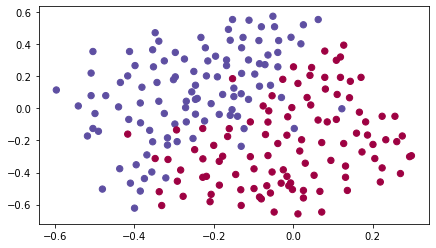

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572419
Cost after iteration 20000: 0.13851642423239133


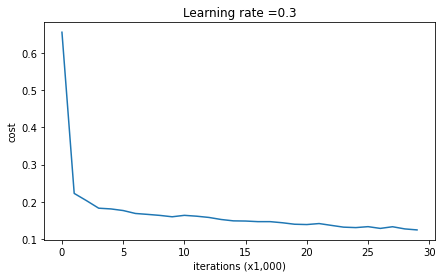

------------------------------ Accuracy ------------------------------------------
On the train set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915
---------------------------- Decision Boundary for Model with He Random initialization --------------------------------


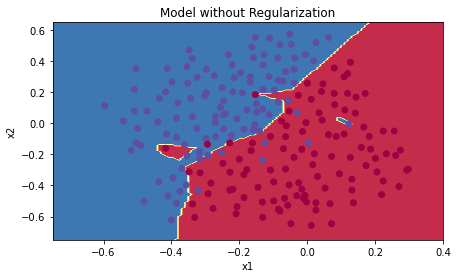

In [56]:
# Data
print('\n\n---------------------------------- Data visualization ------------------------------------\n')
X_train, Y_train, X_test, Y_test = load_2D_dataset()
plt.show()

# Training the model without Regularization (lambd = 0)
parameters = model(
                    X_train, Y_train,
                    learning_rate= 0.3, num_iterations= 30000,
                    print_cost= True,
                    lambd= 0,
                    keep_prob= 1 )

print('------------------------------ Accuracy ------------------------------------------')
print ("On the train set:")
yhat_train = predict( X_train, Y_train, parameters )
print ("On the test set:")
yhat_test = predict( X_test, Y_test, parameters )

print('---------------------------- Decision Boundary for Model without Regularization -----------------------------')
plt.title('Model without Regularization')
axes = plt.gca()
axes.set_xlim( [-0.75,0.40] ); axes.set_ylim( [-0.75,0.65] )
plot_decision_boundary( lambda x: predict_dec(parameters, x.T),
                        X_train, Y_train  )
plt.show()



---------------------------------- Data visualization ------------------------------------



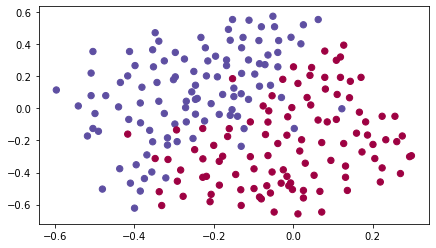

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


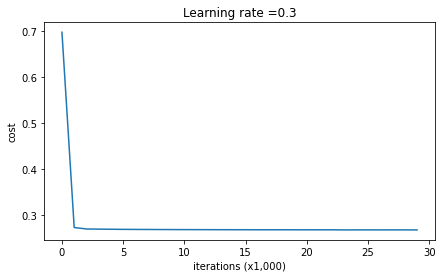

------------------------------ Accuracy ------------------------------------------
On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93
---------------------------- Decision Boundary for Model with Regularization adopted --------------------


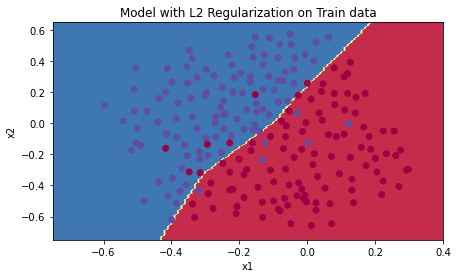

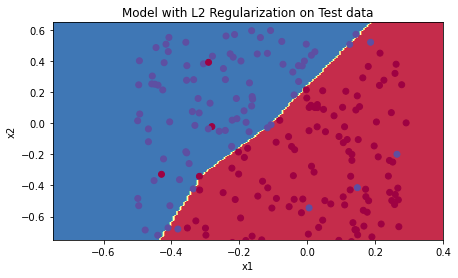

In [59]:
# Training the model adopting Regularization (lambd = 0.7)

print('\n\n---------------------------------- Data visualization ------------------------------------\n')
X_train, Y_train, X_test, Y_test = load_2D_dataset()
plt.show()

parameters = model(
                    X_train, Y_train,
                    learning_rate= 0.3, num_iterations= 30000,
                    print_cost= True,
                    lambd= 0.7,
                    keep_prob= 1 )

print('------------------------------ Accuracy ------------------------------------------')
print ("On the train set:")
yhat_train = predict( X_train, Y_train, parameters )
print ("On the test set:")
yhat_test = predict( X_test, Y_test, parameters )

print('---------------------------- Decision Boundary for Model with Regularization adopted --------------------')
plt.title('Model with L2 Regularization on Train data')
axes = plt.gca()
axes.set_xlim( [-0.75,0.40] ); axes.set_ylim( [-0.75,0.65] )
plot_decision_boundary( lambda x: predict_dec(parameters, x.T),
                        X_train, Y_train  )
plt.show()

plt.title('Model with L2 Regularization on Test data')
axes = plt.gca()
axes.set_xlim( [-0.75,0.40] ); axes.set_ylim( [-0.75,0.65] )
plot_decision_boundary( lambda x: predict_dec(parameters, x.T),
                        X_test, Y_test  )
plt.show()